In [1]:
import os
import dgl
import pickle
import numpy as np
import scipy.sparse as sp
import torch as th
import torch.nn.functional as F

import utils
import models
import data_loader

Using backend: pytorch


In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
dev = th.device('cuda' if th.cuda.is_available() else 'cpu')

# Configuration

In [3]:
data_dir = "../data"
adj_path = os.path.join(data_dir, "adj_matrix_formal_stage.pkl")
feat_path = os.path.join(data_dir, "feature_formal_stage.npy")
label_path = os.path.join(data_dir, "train_labels_formal_stage.npy")
adj_adv_path = os.path.join(data_dir, "adj_adv.pkl")
feat_adv_path = os.path.join(data_dir, "features_adv.npy")
model_dir = "../saved_models"

adj_norm = True
feat_denoise = True
feat_norm = 'atan'
feat_norm_func = utils.feat_norm(feat_norm)

# Data Loading

In [4]:
dataset = data_loader.KddDataset(adj_path, feat_path, label_path)
raw_adj = dataset.adj
raw_features = dataset.features
raw_labels = dataset.labels
train_mask = dataset.train_mask
val_mask = dataset.val_mask
test_mask = dataset.test_mask
size_raw, num_features = raw_features.shape 
test_size = np.sum(test_mask)
size_reduced = size_raw - test_size
num_class = raw_labels.max() + 1

Finished data loading.
NumNodes: 659574
NumEdges: 5757154
NumFeats: 100
NumClasses: 20
NumTrainingSamples: 559574
NumValidationSamples: 50000


In [5]:
adj_adv = pickle.load(open(os.path.join(data_dir, "adj_adv.pkl"), 'rb'))
features_adv = np.load(os.path.join(data_dir, "features_adv.npy"))

In [6]:
adj = sp.vstack([raw_adj, adj_adv[:, :size_raw]])
adj = sp.hstack([adj, adj_adv.T])
adj

<660074x660074 sparse matrix of type '<class 'numpy.float64'>'
	with 5843802 stored elements in COOrdinate format>

In [7]:
# adjacent matrix normalization
if adj_norm: adj = utils.adj_preprocess(adj)

In [8]:
features = np.concatenate([raw_features, features_adv], axis=0)
features = th.FloatTensor(features).to(dev)
print(features.shape)

torch.Size([660074, 100])


# Defense Solution

Our defense solution is based on **Feature Denoising**, **Feature Transformation** and **Topology Adaptive GCN**. We show our final solution that satisfies the evaluation requirements of the competition (inference time <10s in a K80 GPU). Some other methods like adjacent matrix denoising (find malicious connections) are also possible. However, for such a large graph, it would take considerable time to do this. Note that in practice, it is difficult to locate attack nodes since one can randomly arange the order of nodes without affecting model's prediction.

## Step 1: Features Denoising

Denoise the features by using the statistics of original datasets. Here, we use the min-max values, which is the most efficient one. There are other choices, e.g. using co-occurrence between features to find malicious nodes (useful but more expensive).

In [9]:
feat_min = -1.73
feat_max = 1.62
features[th.where(features < feat_min)[0]] = 0
features[th.where(features > feat_max)[0]] = 0

## Step 2: Features Transformation

The idea is to map the features into another space to mitigate transfer attacks. It's effective under black-box settings, when attackers have no information about the target model and the defense mechanism. We experimented three options: **Sigmoid**, **Tanh** and **Arctan**. **Arctan** is the most effective one among them. **Attention**: The defender model need to be trained in the presence of feature transformation. And the range after transformation should be in [-1, 1] not [0, 1], the latter will decrease model performance.

$$Sigmoid: \frac{2}{1+e^{-x}}-1 \in[-1, 1]$$

$$Tanh: tanh(x) \in[-1, 1]$$

$$Arctan: \frac{2\times arctan(x)}{\pi} \in[-1, 1]$$

In [10]:
# Sigmoid
# features = 2 / (1 + th.exp(-features)) - 1
# Tanh
# features = th.tanh(features)
# Arctan
features = 2 * th.atan(features) / th.Tensor([np.pi]).to(dev)

## Step 3: Topology Adaptive GCN

For the model architecture, we adapt TAGCN [1]. Unlike traditional GCN, TAGCN operates convolutions in vertex domain. For example, in the figure, for node 1, we consider all its 2-hop neighbors, and apply convolution on them. We can also do this for 1-hop or 3-hop neighbors. This convolution can extract important topology information. As shown in this formula, TAGCN can use several trainable weights to learn different scales of topology information.

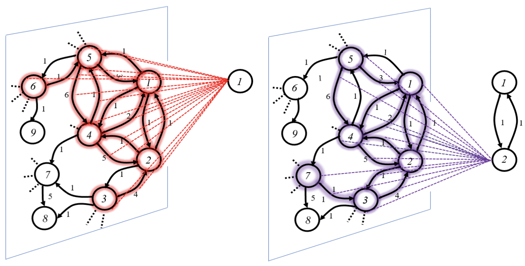

$$X_{i+1}=\sum_{k=1}^{K}A^kX_iG_{k, i}+\textbf{1}b_i$$

where $X_i \in R^{N\times C_i}$, node features at i-th layer; $X_{i+1} \in R^{N\times C_{i+1}}$, node features at (i+1)-th layer; $A \in R^{N\times N}$, adjacent matrix; $G_{k, i} \in R^{C_i\times C_{i+1}}$, learnable weight matrix; $b_i \in R^{C_{i+1}}$, learnable bias.

[1] Du, J., Zhang, S., Wu, G., Moura, J. M., & Kar, S. (2017). Topology adaptive graph convolutional networks. arXiv preprint arXiv:1710.10370.

In [11]:
# model configuration
model_dir = "../saved_models"
model_name = "tagcn_atan_128_3.pkl"
num_hidden = 128
num_layers = 3

In [12]:
model = models.TAGCN(num_features, num_hidden, num_class, num_layers, activation=F.leaky_relu, dropout=0.0)
model_states = th.load(os.path.join(model_dir, model_name), map_location=dev)
model.load_state_dict(model_states)
model = model.to(dev)
model.eval()

TAGCN(
  (layers): ModuleList(
    (0): TAGConv(
      (lin): Linear(in_features=300, out_features=128, bias=True)
    )
    (1): TAGConv(
      (lin): Linear(in_features=384, out_features=128, bias=True)
    )
    (2): TAGConv(
      (lin): Linear(in_features=384, out_features=128, bias=True)
    )
    (3): TAGConv(
      (lin): Linear(in_features=384, out_features=20, bias=True)
    )
  )
  (dropout): Dropout(p=0.0, inplace=False)
)

In [13]:
# model prediction (unknown test labels)
graph = dgl.DGLGraph()
graph.from_scipy_sparse_matrix(adj)
graph.ndata['features'] = features
logits = model(graph, features)
pred = logits.argmax(1)